# Plots for CFMIP poster presentation

Assorted plots aimed to be presented at CFMIP 2023:
- 3D scatter plot of cloud water
- High resolution 2D scatter plot of cloud water
- Computing domain locations on a globe

0,1,2,3,5,7,10,15,20,25,

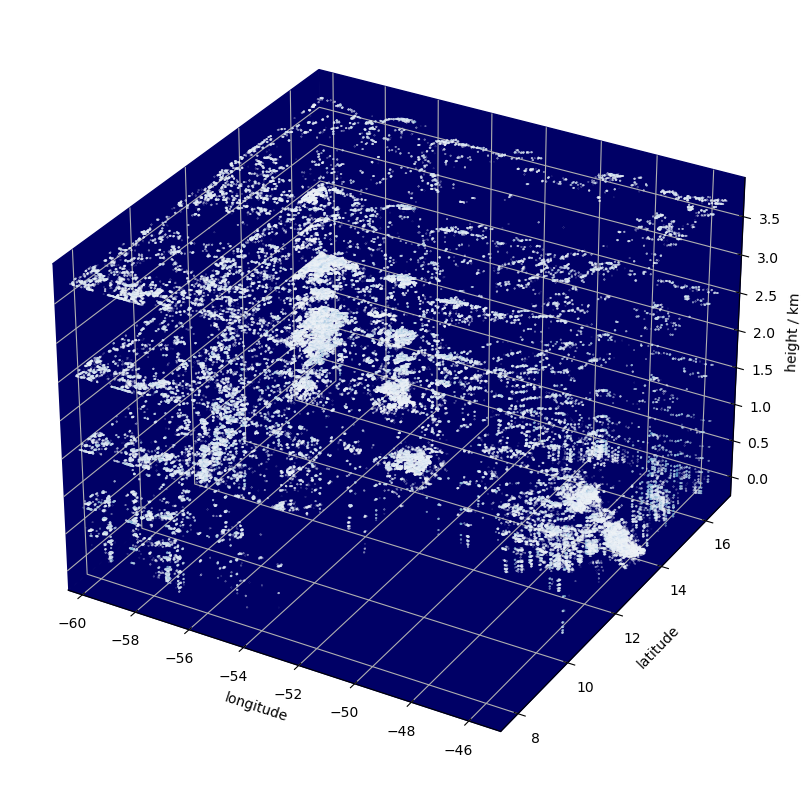

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import xarray as xr
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)
import calculations as cc

def get_example_data():
    path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic/moist_adiabatic_DOM01_3D_20200109T180000Z.nc'
    data = xr.open_dataset(path).isel(time=0).rename({'ncells':'cell'})
    path = '/work/mh0010/m300408/DVC-test/EUREC4A-ICON/EUREC4A/grids/EUREC4A_PR1250m_DOM01.nc'
    grid = xr.open_dataset(path)
    gridvars = list(grid)
    return xr.merge([data,grid]).drop_vars(gridvars)

cmap = plt.get_cmap('Blues')
data = get_example_data()
var = 'qc'
verbose=True
figsize = (10,10)
full_level_height = np.flip(cc.get_z_full()) / 1000
bg_color = (0.0, 0.0, 0.4, 1.0)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection='3d')

levels = [0,1,2,3,5,7,10,15,20,25]
for height in levels:
    if verbose: print(height, end=',')
    x = np.rad2deg(data['clon'])
    y = np.rad2deg(data['clat'])
    z = data[var].isel(height=height)
    mask = z.where(z > 0).values
    x = x[~np.isnan(mask)]
    y = y[~np.isnan(mask)]
    z = z[~np.isnan(mask)]
    z_norm = z.values/np.max(z.values)
    z_norm = 1 - z_norm
    c = cmap(1 - z_norm)
    z = full_level_height[height] * x / x 
    ax.scatter(x, y, z, zdir='z', c=c, alpha=z_norm, s=.003)

for axis in [ax.xaxis, ax.yaxis, ax.zaxis]: axis.set_pane_color(bg_color) # https://stackoverflow.com/a/12623360
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_zlabel('height / km')
ax.set_xlim(np.min(x),np.max(x))
ax.set_ylim(np.min(y),np.max(y))
fig.show()

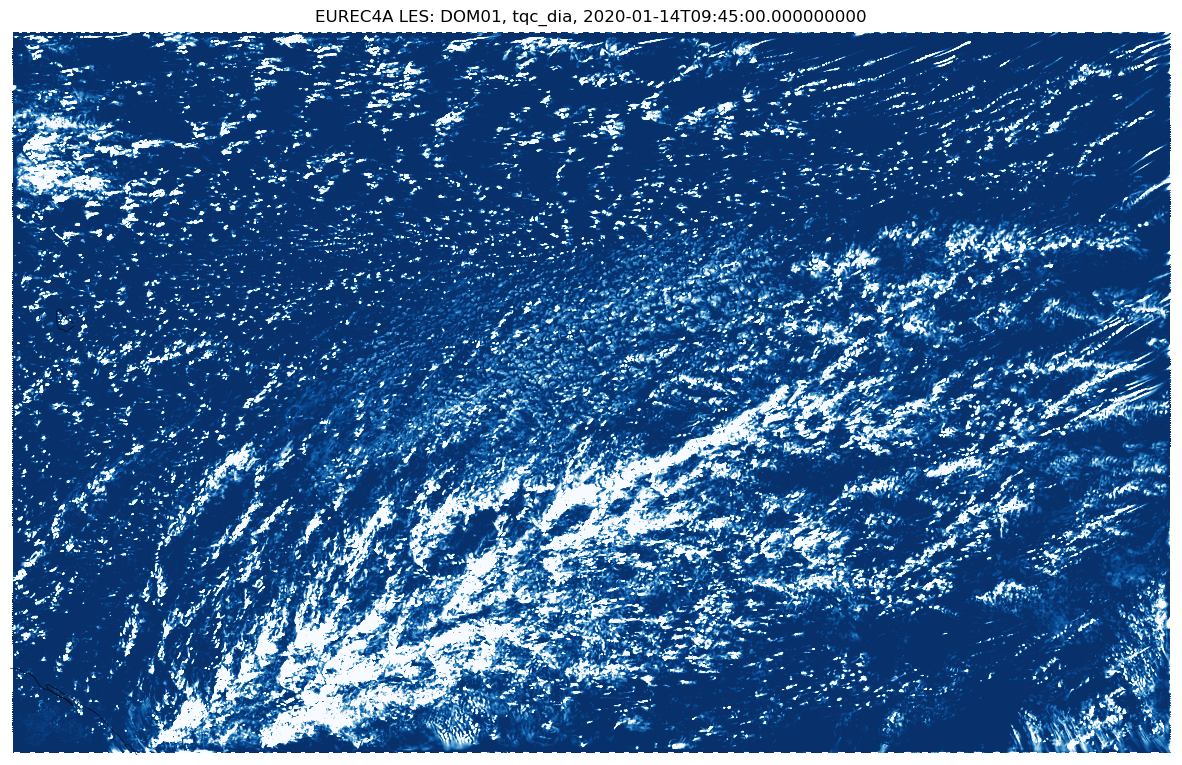

In [15]:
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import datashader
from datashader.mpl_ext import dsshow

import cartopy.crs as ccrs
import cartopy.feature as cf

def grid2latlonlimits(grid):
    limits = (np.min(grid.clon.values), np.min(grid.clat.values), np.max(grid.clon.values), np.max(grid.clat.values))
    return tuple([np.rad2deg(l) for l in limits])

def get_eurec4a_data(domain='DOM01'):
    data = xr.open_zarr(f'https://swift.dkrz.de/v1/dkrz_948e7d4bbfbb445fbff5315fc433e36a/EUREC4A_LES/experiment_2/ICON_{domain}_surface.zarr')
    grid = xr.open_zarr(f'https://swift.dkrz.de/v1/dkrz_948e7d4bbfbb445fbff5315fc433e36a/grids/EUREC4A_PR1250m_{domain}.zarr')
    return xr.merge([data,grid])

def fig_big_eurec4a_mapplot(var="tqc_dia", time=1437, cmap="Blues_r", vlim=(0.0,0.2), domain='DOM01', figsize=(15,10)):
    data = get_eurec4a_data(domain=domain)
    variable = data[var].isel(time=time)
    projection = ccrs.PlateCarree(central_longitude=0)
    coords = projection.transform_points( ccrs.Geodetic(), np.rad2deg(data.clon), np.rad2deg(data.clat),)

    fig, ax = plt.subplots(figsize=figsize ,subplot_kw={"projection": projection})
    fig.canvas.draw_idle()
    ax.add_feature(cf.COASTLINE, linewidth=0.4)
    ax.set_extent(grid2latlonlimits(data), ccrs.PlateCarree())
    artist = dsshow(
        pd.DataFrame({"val": variable.values, "x": coords[:, 0], "y": coords[:, 1],}),
        datashader.Point('x', 'y'),
        datashader.mean('val'),
        vmin=vlim[0],vmax=vlim[1],cmap=cmap,ax=ax,)
    ax.axis('off')
    ax.set_title(f'EUREC4A LES: {domain}, {var}, {data.time.values[time]}')
    return fig, ax

l = 30
# there seem to appear holes in the data at higher resolution
# this already chrashes my 20gb jupyterhub notebook
l = 15

time=1437

fig, ax = fig_big_eurec4a_mapplot(time=time, figsize=(l,l*.66))
fig.show()

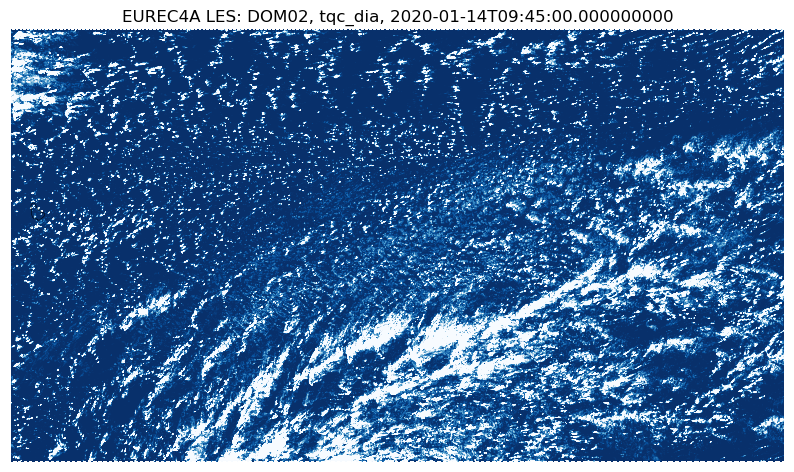

In [16]:
l = 10
fig, ax = fig_big_eurec4a_mapplot(time=time-288, figsize=(l,l*.66), domain='DOM02')
fig.show()

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

# https://stackoverflow.com/q/59020032
def eureca_domain_polygon_corners(domain='DOM01'):
    grid = xr.open_zarr(f"https://swift.dkrz.de/v1/dkrz_948e7d4bbfbb445fbff5315fc433e36a/grids/EUREC4A_PR1250m_{domain}.zarr")
    lonlim = [np.rad2deg(l) for l in (np.min(grid.clon.values), np.max(grid.clon.values))]
    latlim = [np.rad2deg(l) for l in (np.min(grid.clat.values), np.max(grid.clat.values))]
    poly_corners = np.zeros((4, 2), np.float64)
    # polygon corners have to be in counter clockwise order for proper fill
    poly_corners[:,0] = np.asarray([lonlim[1], lonlim[1], lonlim[0], lonlim[0]])
    poly_corners[:,1] = np.asarray([latlim[0], latlim[1], latlim[1], latlim[0]])
    return poly_corners

def add_ax_eureca_plot(fig, pos, central_longitude=-55.0, central_latitude=30.0):
    projection = ccrs.Orthographic(central_latitude=central_latitude, central_longitude=central_longitude)
    projection._threshold /= 1000.
    ax = fig.add_subplot(*pos, projection=projection)
    ax.set_global()
    ax.gridlines()
    ax.add_feature(cfeature.LAND, facecolor='black', alpha=0.4)
    ax.coastlines(linewidth=0.5, color='k', resolution='110m')
    color=(.3,.4,1.0,.4)
    for domain in ['DOM01', 'DOM02']:
        poly_corners = eureca_domain_polygon_corners(domain=domain)
        poly = mpatches.Polygon(poly_corners, closed=True, ec=None, fill=True, lw=1, fc=color, transform=ccrs.Geodetic())
        ax.add_patch(poly)
    return ax

fig = plt.figure(figsize=[8, 8])
ax = add_ax_eureca_plot(fig, pos=(1,1,1))
ax.set_title('EUREC4A-LES computational domains')
fig.show()